In [12]:
import torch
import typing
import numpy as np
import random
import itertools
import pandas as pd
import string
import matplotlib.pyplot as plt
import pickle

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re

import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import time
import math

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## reading in rollout dataset

In [6]:
infile = open('rollout_dataset_pickled','rb')
dataset = pickle.load(infile)
infile.close()

In [9]:
# example of dataset entry
dataset[0]

{'relstat_emb': [189, 184, 212, 213, 178, 199, 185, 180, 178],
 'task_emb': tensor([[[253, 210, 212, 213,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
             0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
             0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]]]),
 'rollout': tensor([[[[[[[  3,   0,   0,  ...,   0,   0,   0]],
 
             [[  3,   0,   0,  ...,   0,   0,   0]],
 
             [[  3,   0,   0,  ...,   0,   0,   0]],
 
             [[  3,   0,   0,  ...,   0,   0,   0]],
 
             [[  3,   0,   0,  ...,   0,   0,   0]],
 
             [[  3,   0,   0,  ...,   0,   0,   0]]],
 
 
            [[[  3,   0,   0,  ...,   0,   0,   0]],
 
             [[170,   0,   0,  ...,   0,   0,   0]],
 
             [[170,   0,   0,  ...,   0,   0,   0]],
 
             [[170,   0,   0,  ...,   0,   0,   0]],
 
             [[170,   0,   0,  ...,   0,   0,   0]],
 
             [[  3,   0,   0,  ...,   0,   0,   0]]],
 
 
           

# Train

## Encoder network

In [10]:
class LinearEncoder(nn.Module):

    def __init__(self, input_size, output_size):
        super(LinearEncoder, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

## Decoder network

In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Training and other helper functions

In [13]:
EOS_token = 1
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, 
          decoder_optimizer, criterion, vocab_size, teacher_forcing_ratio, max_length=15):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    #print('target_length: ', target_length)

    loss = 0

    decoder_input = torch.tensor([[0]], device=device)

    decoder_hidden = encoder(input_tensor).view(1,1,-1)
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            #print('recur decoder_input: ', decoder_input)
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            #print('decoder output: ', decoder_output)
            #print('target tensor di: ', target_tensor[di].view(1))
            loss += criterion(decoder_output, target_tensor[di].view(1).long())
            decoder_input = target_tensor[di].view(1).long() # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di].view(1).long())
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

def pad_rollouts(rollout, max_len):
    rollout_len = rollout.size()[0]
    if rollout_len > max_len - 1:
        print('rollout too long')
        return None
    remaining = max_len - rollout_len
    padding = torch.zeros((remaining, 1, 1, 6, 6, 1, 8))
    padded_rollout = torch.cat((rollout, padding), 0)
    return padded_rollout

#pads all relevant statement embeddings to some max len and returns their flattened tensor
def preprocess_relstat_emb(relstat_emb, max_len = 15):
    l = torch.zeros([1])
    torch_relstat = torch.tensor(relstat_emb)
    l = torch.cat((l,torch_relstat))
    if l.size(0) > max_len:
        print('relstat too long')
        return None
    while l.size()[0] < max_len:
        l = torch.cat((l, torch.ones([1])))
        l = l.flatten()
    return l

def flatten_all(dataset, max_len_rollout, max_len_relstat):
    flat_dataset = []
    for i in range(len(dataset)):
        entry = []
        flat_task = torch.flatten(dataset[i]['task_emb'])
        padded_rollout = pad_rollouts(dataset[i]['rollout'], max_len_rollout)
        flat_rollout = padded_rollout.flatten()
        processed_relstat = preprocess_relstat_emb(dataset[i]['relstat_emb'], max_len_relstat)
        entry.append(torch.cat((flat_task, flat_rollout)))
        entry.append(processed_relstat)
        flat_dataset.append(entry)
    return flat_dataset

def trainIters(dataset, encoder, decoder, n_iters, output_size, teacher_forcing_low, print_every=100, plot_every=10, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = dataset
    criterion = nn.NLLLoss()
    
    
    for iter in range(1, n_iters + 1):
        teacher_forcing_ratio = 1 - (iter / n_iters) * teacher_forcing_low
        
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion, output_size, teacher_forcing_ratio)
        #print('loss: ', loss)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
    showPlot(plot_losses)
    return plot_losses

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [5]:
# flat_dataset = flatten_all(dataset, 21, 12)

## Flatten rollouts, train-test split, and random shuffling

In [14]:
flat_dataset = flatten_all(dataset, 30, 15)
flat_train = flat_dataset[:99000]
flat_test = flat_dataset[1000:]
random.shuffle(flat_train)

In [16]:
#inspecting input dimensionality
input_size = flat_dataset[0][0].size()[0]
print('input size: ', input_size)

input size:  8680


## Training

In [25]:
output_size = 262
latent_size = 200
encoder = LinearEncoder(input_size, latent_size).to(device)
decoder = DecoderRNN(latent_size, output_size).to(device)

In [26]:
#set this to around a million for interesting results
n_iters = 1000

0m 1s (- 0m 14s) (100 10%) 3.3560
0m 3s (- 0m 12s) (200 20%) 1.6682
0m 4s (- 0m 10s) (300 30%) 1.2949
0m 5s (- 0m 8s) (400 40%) 1.1347
0m 7s (- 0m 7s) (500 50%) 0.9729
0m 9s (- 0m 6s) (600 60%) 0.9083
0m 11s (- 0m 4s) (700 70%) 0.9981
0m 12s (- 0m 3s) (800 80%) 0.9510
0m 14s (- 0m 1s) (900 90%) 1.0415
0m 15s (- 0m 0s) (1000 100%) 1.0557


<Figure size 432x288 with 0 Axes>

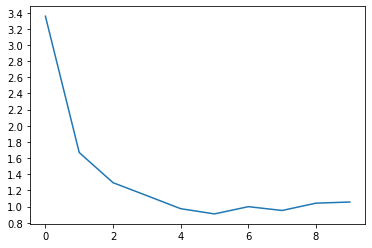

In [27]:
losses = trainIters(flat_train, encoder, decoder, n_iters, output_size, 0.5, print_every=100, plot_every=100, learning_rate=0.001)

# Evaluate

In [33]:
# vocabulary of RTFM
vocab = ['pad', 'eos', '', 'wall', 'door', 'orcishdagger', 'dagger', 'silverdagger', 'athame', 
         'elvendagger', 'wormtooth', 'knife', 'stiletto', 'scalpel', 'crysknife', 'axe', 'battleaxe', 
         'pickaxe', 'dwarvishmattock', 'orcishshortsword', 'shortsword', 'dwarvishshortsword', 
         'elvenshortsword', 'broadsword', 'runesword', 'elvenbroadsword', 'longsword', 'katana', 
         'twohandedsword', 'tsurugi', 'scimitar', 'silversaber', 'club', 'aklys', 'mace', 'morningstar', 
         'flail', 'grapplinghook', 'warhammer', 'quarterstaff', 'partisan', 'fauchard', 'glaive', 'becdecorbin', 
         'spetum', 'lucernhammer', 'guisarme', 'ranseur', 'voulge', 'billguisarme', 'bardiche', 'halberd', 
         'orcishspear', 'spear', 'silverspear', 'elvenspear', 'dwarvishspear', 'javelin', 'trident', 'lance', 
         'orcishbow', 'orcisharrow', 'bow', 'arrow', 'elvenbow', 'elvenarrow', 'yumi', 'ya', 'silverarrow', 
         'sling', 'flintstone', 'crossbow', 'crossbowbolt', 'dart', 'shuriken', 'boomerang', 'bullwhip', 
         'rubberhose', 'unicornhorn', 'unarmed', 'basedagger', 'baseknive', 'baseaxe', 'basepickaxe', 
         'baseshortsword', 'basebroadsword', 'baselongsword', 'basetwohandedsword', 'basescimitar', 
         'basesaber', 'baseclub', 'basemace', 'basemorningstar', 'baseflail', 'basehammer', 'basequarterstave', 
         'basepolearm', 'basespear', 'basetrident', 'baselance', 'basebow', 'basesling', 'basecrossbow', 'basedart', 
         'baseshuriken', 'baseboomerang', 'basewhip', 'baseunicornhorn', 'hawaiianshirt', 'tshirt', 'leatherjacket', 
         'leatherarmor', 'orcishringmail', 'studdedleatherarmor', 'ringmail', 'scalemail', 'orcishchainmail', 
         'chainmail', 'elvenmithrilcoat', 'splintmail', 'bandedmail', 'dwarvishmithrilcoat', 'bronzeplatemail', 
         'platemail', 'crystalplatemail', 'dragonscales', 'mummywrapping', 'orcishcloak', 'dwarvishcloak', 
         'leathercloak', 'oilskincloak', 'fedora', 'dentedpot', 'elvenleatherhelm', 'helmet', 'orcishhelm', 
         'dwarvishironhelm', 'leathergloves', 'smallshield', 'orcishshield', 'urukhaishield', 'elvenshield', 
         'dwarvishroundshield', 'largeshield', 'lowboots', 'highboots', 'ironshoes', 'baseshirt', 'basesuit', 
         'basedragonsuit', 'basecloak', 'basehelm', 'baseglove', 'baseshield', 'baseboot', 'amulet', 'ring', 
         'weapon', 'armour', 'accessory', 'agent', 'player', 'queuedagent', 'monster', 'stationarymonster', 
         'dragon', 'hostilemonster', 'randommonster', 'structure', 'unobservable', 'empty', 'baseitem', 
         'basemonster', 'move', 'around', 'welcome', 'to', 'rtfm', '.', 'cold', 'fire', 'poison', 'lightning', 
         'you', 'are', 'beat', ',', '{', '}', 'wolf', 'jaguar', 'panther', 'goblin', 'bat', 'imp', 'shaman', 
         'ghost', 'zombie', 'grandmasters', 'blessed', 'shimmering', 'gleaming', 'fanatical', 'mysterious', 
         'soldiers', 'arcane', 'star', 'alliance', 'order', 'of', 'the', 'forest', 'rebel', 'enclave', 'sword', 
         'polearm', 'cutlass', 'modifiers', 'weapons', 'element', 'monsters', 'items', 'effective', 'against', 
         'defeated', 'by', 'should', 'use', 'get', 'slay', 'useful', 'for', 'good', 'not', 'weak', 'slain', 
         'group', 'belong', 'contains', 'on', 'team', 'consists', 'same', '-', 'they', 'has', 'following', 
         'members', ':', 'is', 'made', 'up', 'make', 'defeat', 'must', 'be', 'needs', 'beaten', 'evil', 'fight', 
         'in', 'from']

## Evaluation helper functions

In [34]:
def clean_pred(pred):
    newls = []
    for l in pred:
        if l == 'pad' or l == '<EOS>':
            continue
        newls.append(l)
    return newls

def clean_eval(targets, preds):
    cleant = []
    for t in targets:
        clean_tar = clean_target(t)
        cleant.append(clean_tar)
    
    cleanp = []
    for p in preds:
        clean_pre = clean_pred(p)
        cleanp.append(clean_pre)
    return cleant, cleanp

def clean_target(target):
    ls = target.split()
    newls = []
    for l in ls:
        if l == 'pad' or l == 'eos':
            continue
        newls.append(l)
    return newls

def idx_to_sent(idxs, vocab):
    sent = ''
    idxs = idxs.int()
    for i in idxs:
        sent += vocab[i] +' '
    return sent

def evaluate(encoder, decoder, input_tensor, vocab, max_length=15):
    with torch.no_grad():
        latent = encoder(input_tensor)

        decoder_input = torch.tensor([[0]], device=device)  # SOS

        decoder_hidden = latent.view(1,1,-1)

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == 1:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(vocab[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words
    
def evaluateRandomly(encoder, decoder, pairs, vocab, n=10):
    target = []
    predicted = []
    for i in range(n):
        pair = pairs[i]
        target_statements = idx_to_sent(pair[1], vocab)
        target.append(target_statements)
        output_words = evaluate(encoder, decoder, pair[0], vocab)
        predicted.append(output_words)
        #output_sentence = ' '.join(output_words)
        #print('<', output_sentence)
        #print('')
    return target, predicted

In [35]:
targets, preds = evaluateRandomly(encoder, decoder, flat_train, vocab, n=10)

In [36]:
for i in range(len(targets)):
    print('target: ', targets[i])
    print('preds: ', preds[i])

target:  pad blessed beat poison . wolf are rebel enclave . eos eos eos eos eos 
preds:  ['pad', 'gleaming', 'beat', 'poison', '.', 'panther', 'are', 'order', 'of', 'the', 'forest', '.', '<EOS>']
target:  pad shimmering beat fire . panther are star alliance . eos eos eos eos eos 
preds:  ['pad', 'gleaming', 'beat', 'poison', '.', 'panther', 'are', 'order', 'of', 'the', 'forest', '.', '<EOS>']
target:  pad jaguar are order of the forest . blessed beat lightning . eos eos eos 
preds:  ['pad', 'gleaming', 'beat', 'poison', '.', 'panther', 'are', 'order', 'of', 'the', 'forest', '.', '<EOS>']
target:  pad blessed beat lightning . jaguar are rebel enclave . eos eos eos eos eos 
preds:  ['pad', 'gleaming', 'beat', 'poison', '.', 'panther', 'are', 'order', 'of', 'the', 'forest', '.', '<EOS>']
target:  pad gleaming beat fire . panther are order of the forest . eos eos eos 
preds:  ['pad', 'gleaming', 'beat', 'poison', '.', 'panther', 'are', 'order', 'of', 'the', 'forest', '.', '<EOS>']
target: 

## BLEU Score

In [ ]:
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu 
reference = [['this', 'is', 'a', 'test']]
candidate = ['this', 'is', 'a', 'test']
print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))